In [1]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
import cv2
import torch
import imageio
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm.notebook import tqdm
from torch import Tensor
from itertools import compress, cycle
from collections import OrderedDict
from scipy.interpolate import griddata
from IPython.display import Image

from utilities.utils import *

from src.plotting import Plotter
from src.gl_solver import GLSolver
from src.parameters_init import ParametersInit
from src.random_input_field import RandomInputField

import warnings
warnings.filterwarnings('ignore')

EPOCHS = 20_000
LR = 1

GETTING HANDS DIRTY WITH THE NEURAL NETWORKS

$$
\begin{aligned}
\partial_{t} A &= \mu A+\Delta A-|A|^{2} A
\end{aligned}
$$

In [3]:
class GALAXYNET(nn.Module):
    def __init__(self, layers_list, activation_function_list = None, linm = None):
        super(GALAXYNET, self).__init__()
        self._depth = len(layers_list) - 1
        
        if activation_function_list is None:
            activation_function_list = [F.softplus for _ in range(self._depth - 1)]
            
        if linm is None:
            linm =  np.tril(np.ones(self._depth + 1, dtype = int))
        lin = linm@layers_list
        
        self._activation_function_list = activation_function_list
        
        self._Wtmx = nn.Sequential(*[torch.nn.Linear(lin[i], layers_list[i+1], dtype = torch.float64) for i in range(self._depth)])
        self._linm = linm
        
        self.optimizer = torch.optim.Adam( params = self._Wtmx.parameters(), lr=0.01 )    
        
    def forward(self, x):
        layers = [x,self._Wtmx[0](x)]
        for i in range(1, self._depth):
            layers[i] = self._activation_function_list[i-1](layers[i])
            ind = self._linm[i]
            inpind = np.where(ind)[0]
            inp = torch.concat([layers[i] for i in inpind], dim=1)
            layers.append(self._Wtmx[i](inp))
        return layers[-1]        

    def predict(self, x):
        self._Wtmx.eval()
        if type(x) is not torch.Tensor:
            x = torch.tensor(x, dtype = torch.float64).to(device)
        y =  self.forward(x).cpu().detach().numpy()
        return y[:,0] + y[:,1]*1j    

    def rmsef(self, y, y_pred):
        mseloss = torch.sum((y_pred - y)**2,dim=1)
        return torch.sum(torch.sqrt(mseloss))   

    def fastrmsebatchtrain(self, x, y, epochs=100, batch_size = 64):
        from torch.utils.data import DataLoader

        x = torch.tensor(x, dtype = torch.float64).to(device)
        y = torch.tensor(y, dtype = torch.float64).to(device)
        dataloader = DataLoader(dataset = torch.hstack((x,y)), batch_size=batch_size, shuffle=True)
        
        self.optimizer.zero_grad()
        L = []
        
        import math
        batchiter = (epochs * batch_size)  // x.size()[0]
        epochs =  batchiter * math.ceil(x.size()[0] / batch_size)
        
        pbar = tqdm(total=epochs)
        try:
            for _ in range(batchiter):
                for i, tmp in enumerate(dataloader):
                    (tmpx, tmpy, tmpt, tmpu_real, tmpu_img) = tmp.T
                    X = torch.stack((tmpx,tmpy,tmpt)).T
                    U = torch.stack((tmpu_real, tmpu_img)).T

                    y_pred = self.forward(X)
                    loss = self.rmsef(y_pred,U)
                    L.append(loss.cpu().detach().numpy())
                    loss.backward()
                    self.optimizer.step()
                    self._Wtmx.zero_grad()
                    # Update the progress bar
                    pbar.update(1)
        except:
            pass
        finally:
            # Close the progress bar
            pbar.close()          
        return L       

In [4]:
class GALAXYPINN(GALAXYNET):
    def __init__(self,*args,**kwargs):
        super(GALAXYPINN, self).__init__(*args,**kwargs)
#         myu = torch.randn(4, 2, dtype=torch.float64).to(device)
#         myu = nn.Parameter(myu)
#         self._Wtmx.register_parameter('myu', myu)
#         self.myuparam = myu
#         myu = transform_and_stack(myu, 4, 200).to(device).clone().requires_grad_(True)
#         self.myu = myu.view(200, 4, 4)
        self.myureset()
    
    def myureset(self):
        myu = torch.randn(mem_rate, Nx, Ny, dtype=torch.float64).to(device)
        myu = torch.abs(myu)
        myu = nn.Parameter(myu)
        self._Wtmx.register_parameter('myu', myu)
        self.myuparam = myu
        self.myu = myu
    
    def loaddata_precalculate(self,x):
        x = torch.tensor(x, dtype = torch.float64, requires_grad=True).to(device)
        myuloss = MYULOSS(*tuple(x.T),self,y)
        myuloss.calculate_f_withoutmyu()
        self.myuloss = myuloss
    
    def myutrain(self, epochs=100, lr = 0.01):
        myuoptimizer = torch.optim.Adam( params = [self.myuparam], lr=lr ) 
        myuoptimizer.zero_grad()

        for _ in tqdm(range(epochs)):
            self.myuloss.fmse(self.myu).backward(retain_graph=True)
            myuoptimizer.step()
            myuoptimizer.zero_grad()
        
        FMSE = self.myuloss.FMSE
        self.myuloss.clear()
        return FMSE

In [5]:
class MYULOSS:
  def __init__(self, x, y, t, net, verbose = 0):
      self.msef = nn.MSELoss()
      self.FMSE = []
      self.x = x
      self.y = y
      self.t = t
      self.y_pred = net.forward(torch.stack((x,y,t)).T)
        
  def plot(self, title= 'MYU training'):
    plt.plot(self.FMSE)
    plt.yscale('log')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('FMSE')
    self.clear()
    
  def clear(self):
    self.FMSE = []
    
  def fmse(self, myu):
    f_loss = torch.mean(torch.abs(self.net_f(myu)) ** 2)
    self.FMSE.append(f_loss.cpu().detach().numpy())
    return f_loss
  
  def net_f(self, myu, verbose = 0):
        return self.f_withoutmyu - myu*self.u 
    
  def calculate_f_withoutmyu(self):
        torch.autograd.set_detect_anomaly(True)
        x,y,t = self.x, self.y, self.t
        
        ru = self.y_pred[:,0]
        iu = self.y_pred[:,1]

        (ru_t, ru_x, ru_y) = torch.autograd.grad(ru, (t, x, y), grad_outputs=torch.ones_like(ru), create_graph=True, retain_graph=True)
        (iu_t, iu_x, iu_y) = torch.autograd.grad(iu, (t, x, y), grad_outputs=torch.ones_like(iu), create_graph=True, retain_graph=True)

        (ru_xx,) = torch.autograd.grad(ru_x, (x), grad_outputs=torch.ones_like(ru_x), create_graph=True)
        (iu_xx,) = torch.autograd.grad(iu_x, (x), grad_outputs=torch.ones_like(iu_x), create_graph=True)

        (ru_yy,) = torch.autograd.grad(ru_y, (y), grad_outputs=torch.ones_like(ru_y), create_graph=True)
        (iu_yy,) = torch.autograd.grad(iu_y, (y), grad_outputs=torch.ones_like(iu_y), create_graph=True)

        u =( ru + iu * 1j).view(mem_rate, Nx, Ny)
        u_t = (ru_t + iu_t * 1j).view(mem_rate, Nx, Ny)
        u_xx =( ru_xx + iu_xx *1j).view(mem_rate, Nx, Ny)
        u_yy = (ru_yy + iu_yy *1j).view(mem_rate, Nx, Ny)
        self.u = u.cpu().detach()
            
        f_withoutmyu = u_t - (u_xx + u_yy) + torch.pow(torch.abs(u), 2)*u #- myu*u
        free_memory(u_t, u_xx, u_yy)
        self.f_withoutmyu = f_withoutmyu.cpu().detach()
        torch.autograd.set_detect_anomaly(False)
      
def free_memory(*variables):
    del variables
    torch.cuda.empty_cache()

In [6]:
def nettrain():
    L1 = net.fastrmsebatchtrain(x = X_star, y = u_star, epochs = 100000)

    net.optimizer.param_groups[0]['lr'] = 0.001
    L2 = net.fastrmsebatchtrain(x = X_star, y = u_star, epochs = 100000)

    plt.plot(L1)
    plt.yscale('log')
    plt.xlabel('epochs')
    plt.ylabel('Custom Loss')
    plt.title('Training of the AllInputNet \n lr=0.01')
    plt.savefig(f'{mtlibpath_prefix}_allinputnet001.png')
    plt.show()

    plt.plot(L2)
    plt.yscale('log')
    plt.xlabel('epochs')
    plt.ylabel('Custom Loss')
    plt.title('Training of the AllInputNet \n lr=0.001')
    plt.savefig(f'{mtlibpath_prefix}_allinputnet0001.png')
    plt.show()

## calculating myus

In [7]:
def runmyu():
    calcmyu()
    plotmyu()

In [8]:
def calcmyu():
    net.loaddata_precalculate(X_star)
    net.myureset()
    global u
    u = net.myuloss.u

In [9]:
def plotmyu():
    figure, axes = plt.subplots(nrows = 2,ncols = 2, figsize=(8, 4.5))

    for lr, ax in zip([10,3,1,0.3],np.array(axes).flatten()):
        L = net.myutrain(lr = lr, epochs = 10)
        ax.plot(L)    
        ax.set_yscale('log')
        ax.set_title(f'lr={lr}')

    figure.text(0.02, 0.5, 'FMSE', ha='center', va='center', rotation='vertical')
    figure.text(0.5, 0.002, 'epochs', ha='center', va='center')
    figure.suptitle('MYU Training', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'{mtlibpath_prefix}_myutraining.png')
    plt.show()

## Visualizing and saving plot gifs

In [10]:
def gifplot():
    myuplot()
    plt.show()
    originalplot()
    plt.show()
    Agifplot()
    plt.show()

In [11]:
def myuplot():
    ploter = Plotter(net.myu.cpu().detach().numpy())
    ploter.output_animation(mem_rate, save_gif=True, file_name=rf"{path}_myupred.gif")

In [12]:
def originalplot():
    ploter = Plotter(myu_original.squeeze(0))
    ploter.output_animation(mem_rate, save_gif=True, file_name=rf"{path}_myuorig.gif")

In [13]:
def Agifplot():
    create_gifs(
        memory_rate=mem_rate,
        u_pred=net.predict(X_star),
        original=A_original,
        save=True,
        path_for_gif=path+".gif",
        duration=500,
        title=" "
    )
    Image(filename=path+".gif")

In [14]:
def isdone(string):
    if not os.path.exists('plot/done.txt'):
        print("THE FILE plot/done.txt does not exist double check it")
    
    # Check if the string exists in the file
    with open('plot/done.txt', 'r') as file:
        contents = file.read()
        if string in contents:
            return True
        else:
            return False
import os
def setdone(string):
    # Write the string to the file
    with open('plot/done.txt', 'a') as file:
        file.write(string + '\n')

# Example usage
setdone("Hello, world!")  # Writes "Hello, world!" to the file
print(isdone("Hello, world!"))  # Prints True
print(isdone("Foo"))  # Prints False


True
False


In [15]:
def saveresults(prefix):
    np.save(prefix + "_myu_pred.npy",net.myu.cpu().detach().numpy())
    np.save(prefix + "_myu_original.npy",myu_original.squeeze(0))
    np.save(prefix + "_A_pred.npy",u)
    np.save(prefix + "_A_original.npy",A_original)

### RUN WITH CUSTOM PARAMETERS 

In [16]:
!mkdir -p plot/data

Nx=60-time_period_parameter=40-dt=0.005-Lx=7-input_to_defect_ratio=100


100%|███████████████████████████████████████| 200/200 [00:00<00:00, 2201.01it/s]


Unique Myus count	 180
Max value of myu:	 88.42369900629959
Min value of myu:	 32.5954719470796
Unique values: [32.5954719470796, 33.425117904784386, 34.3481681521083, 34.953412569847785, 35.23409558348635, 36.91997215322985, 37.13525944085998, 39.50913885834115, 40.828791687744385, 41.01107297858484, 41.79660242134719, 42.29924728898496, 42.65056975088027, 42.759853320682154, 43.701966388723925, 43.71730707839817, 43.84173973985752, 43.93145505419134, 44.08419437026836, 44.109546290126076, 44.16752863673451, 46.723194541969455, 46.84900770664998, 47.265799181367164, 47.29002746755052, 48.108441114463645, 48.17510046002758, 48.802863861321036, 49.2103401950101, 49.53505262195116, 49.75814119331408, 49.78165764261443, 49.995560408683474, 50.03940536123349, 50.77001035187256, 50.998019123974416, 51.32993073273145, 51.50004911766405, 51.64211645395351, 51.66134530600756, 51.708350309536215, 52.06810417948089, 52.11428217208176, 52.654379463951564, 52.73198343740367, 52.745442194392794, 52

100%|███████████████████████████████████| 90000/90000 [01:11<00:00, 1265.81it/s]


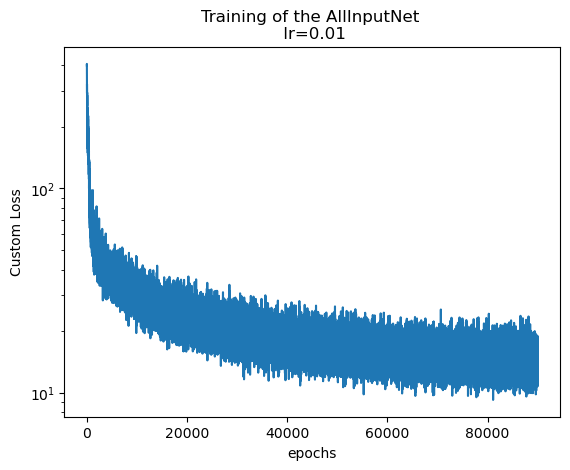

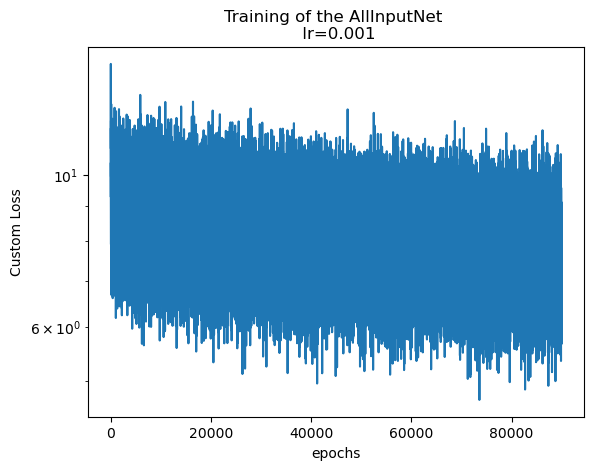

In [ ]:
range_Nx = [60]
range_time_period_parameter = [40]
range_dt = [0.005]
range_Lx = [6,7,8,9]
range_input_to_defect_ratio = [10*10]

for Nx in range_Nx:
 for dt in range_dt:
  for time_period_parameter in range_time_period_parameter:
   for Lx in range_Lx:
    for input_to_defect_ratio in range_input_to_defect_ratio:     
        uid = f"Nx={Nx}-time_period_parameter={time_period_parameter}-dt={dt}-Lx={Lx}-input_to_defect_ratio={input_to_defect_ratio}"
        if isdone(uid): continue

        device='cpu'
        print(uid)

        path = f"plot/{uid}"
        mtlibpath_prefix = f"plot/{uid}"

        Ny=Nx

        Ly=Lx

        T_end = 1

        N_ITERATIONS = int(T_end / dt)
        A_norm, A_original, mem_rate, myu_original = compute_A_norm(
            Nx=Nx, 
            Ny=Ny, 
            input_to_defect_ratio=input_to_defect_ratio, 
            mean=5.4, 
            std_deviation=0.8, 
            time_period=80, 
            Lx=Lx, 
            Ly=Ly, 
            dt=dt, 
            T_End=T_end, 
            parallel_runs=1, 
            input_scale=0.75, 
            mem_coef=1, 
            time_period_parameter=time_period_parameter, 
            _mean=5.4, 
            std_deviation_run_computation=0.8,
            input_myu=None
        )

        x = np.linspace(0, Lx, Nx).flatten()[:, None]
        y = np.linspace(0, Ly, Ny).flatten()[:, None]
        t = np.linspace(0, T_end, N_ITERATIONS).flatten()[:, None]

        Exact = A_original.squeeze(0)

        X, T, Y = np.meshgrid(x, t, y)

        X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None], T.flatten()[:, None]))
        u_star = Exact.flatten()
        u_star = np.hstack([u_star.real[:, None],u_star.imag[:, None]])

        torch.manual_seed(0)
        net = GALAXYPINN([3,8,32,64,32,8,2]).to(device)

        nettrain()
        runmyu()
        gifplot()
        setdone(uid)
        saveresults(f"plot/data/{uid}")